In [87]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from sklearn.model_selection import LeaveOneOut
import os
import cv2
import numpy as np
from PIL import Image
from copy import deepcopy

In [88]:
# Dataset class untuk memuat sequential frames
class DrowsinessDataset(Dataset):
    def __init__(self, video_folders, labels, transform=None, num_frames=30):
        self.video_folders = video_folders
        self.labels = labels
        self.transform = transform
        self.num_frames = num_frames
    
    def __len__(self):
        return len(self.video_folders)
    
    def __getitem__(self, idx):
        folder_path = self.video_folders[idx]
        label = self.labels[idx]
        
        # Load semua frames dari folder
        frames = []
        for i in range(1, self.num_frames + 1):
            frame_path = os.path.join(folder_path, f"{i:02d}.jpg")
            
            if os.path.exists(frame_path):
                img = Image.open(frame_path).convert('RGB')
                if self.transform:
                    img = self.transform(img)
                frames.append(img)
            else:
                # Jika frame tidak ada, gunakan frame kosong
                if self.transform:
                    img = self.transform(Image.new('RGB', (224, 224)))
                else:
                    img = torch.zeros(3, 224, 224)
                frames.append(img)
        
        # Stack frames menjadi tensor (num_frames, channels, height, width)
        frames = torch.stack(frames)
        
        return frames, label

# Transform untuk preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Path ke folder output
output_dir = r"c:\Users\andre\Documents\Binus\Lomba\DataSlayer 3\output"
drowsiness_dir = os.path.join(output_dir, "drowsiness_faces")
non_drowsiness_dir = os.path.join(output_dir, "non-drowsiness_faces")

# Kumpulkan semua folder video dan labelnya
video_folders = []
labels = []

# Label 1 untuk drowsiness
for folder_name in os.listdir(drowsiness_dir):
    folder_path = os.path.join(drowsiness_dir, folder_name)
    if os.path.isdir(folder_path) and folder_name != "manifest.csv":
        video_folders.append(folder_path)
        labels.append(1)  # drowsiness = 1

# Label 0 untuk non-drowsiness
for folder_name in os.listdir(non_drowsiness_dir):
    folder_path = os.path.join(non_drowsiness_dir, folder_name)
    if os.path.isdir(folder_path) and folder_name != "manifest.csv":
        video_folders.append(folder_path)
        labels.append(0)  # non-drowsiness = 0

# Buat dataset untuk SEMUA data (tidak ada split)
full_dataset = DrowsinessDataset(video_folders, labels, transform=transform)

# Print informasi dataset
print(f"Total data: {len(video_folders)}")
print(f"Drowsiness samples: {sum(labels)}")
print(f"Non-drowsiness samples: {len(labels) - sum(labels)}")
print(f"\nMenggunakan Leave-One-Out Cross Validation")
print(f"Setiap fold: {len(video_folders)-1} training, 1 validation")

Total data: 120
Drowsiness samples: 60
Non-drowsiness samples: 60

Menggunakan Leave-One-Out Cross Validation
Setiap fold: 119 training, 1 validation


In [89]:
import timm
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [90]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
# CUDA optimization
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")

Using device: cuda
GPU: NVIDIA GeForce GTX 1650 Ti
CUDA Version: 11.8


In [91]:
class EfficientNetFeatureExtractor(nn.Module):
    def __init__(self, feature_dim=256, freeze=True):
        super().__init__()
        # Load pretrained EfficientNetB0
        self.effnet = timm.create_model('efficientnet_b0', pretrained=True, num_classes=0)
        
        # Freeze backbone
        if freeze:
            for param in self.effnet.parameters():
                param.requires_grad = False
        
        # Bottleneck layer: 1280 -> 256
        self.bottleneck = nn.Sequential(
            nn.Linear(1280, feature_dim),
            nn.ReLU(),
            nn.Dropout(0.2)  # Reduced dropout for small dataset
        )
    
    def forward(self, x):
        # x: (B*T, C, H, W)
        features = self.effnet(x)  # (B*T, 1280)
        features = self.bottleneck(features)  # (B*T, 256)
        return features

In [92]:
class LSTMEncoder(nn.Module):
    def __init__(self, input_size=256, hidden_size=128, num_layers=1, bidirectional=True):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=0.0  # No dropout karena 1 layer
        )
    
    def forward(self, x):
        # x: (B, T, F)
        out, (h_n, c_n) = self.lstm(x)
        # out: (B, T, hidden_size * 2) jika bidirectional
        # Ambil output di time step terakhir
        last_out = out[:, -1, :]  # (B, hidden_size * 2)
        return last_out

In [93]:
class MLPClassifier(nn.Module):
    def __init__(self, input_size=256, hidden_size=64, num_classes=1):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.3),  # Reduced dropout for small dataset
            nn.Linear(hidden_size, num_classes)
        )
    
    def forward(self, x):
        return self.classifier(x)

In [94]:
class DrowsinessDetector(nn.Module):
    def __init__(self, feature_dim=256, lstm_hidden=128, mlp_hidden=64, freeze_cnn=True):
        super().__init__()
        self.feature_extractor = EfficientNetFeatureExtractor(feature_dim=feature_dim, freeze=freeze_cnn)
        
        lstm_output_size = lstm_hidden * 2  # bidirectional
        self.temporal_encoder = LSTMEncoder(input_size=feature_dim, hidden_size=lstm_hidden, bidirectional=True)
        self.classifier = MLPClassifier(input_size=lstm_output_size, hidden_size=mlp_hidden, num_classes=1)
    
    def forward(self, x):
        # x: (B, T, C, H, W)
        B, T, C, H, W = x.shape
        
        # Reshape untuk feature extraction
        x = x.view(B * T, C, H, W)  # (B*T, C, H, W)
        
        # Extract features
        features = self.feature_extractor(x)  # (B*T, feature_dim)
        
        # Reshape kembali untuk LSTM
        features = features.view(B, T, -1)  # (B, T, feature_dim)
        
        # LSTM encoding
        lstm_out = self.temporal_encoder(features)  # (B, lstm_hidden*2)
        
        # Classification
        logits = self.classifier(lstm_out)  # (B, 1)
        
        return logits.squeeze(-1)  # (B,)

In [95]:
# Model akan dibuat ulang di setiap fold LOOCV
# Ini hanya untuk melihat arsitektur
model_template = DrowsinessDetector(
    feature_dim=256,
    lstm_hidden=128,
    mlp_hidden=64,
    freeze_cnn=True
).to(device)

# Hitung parameter
total_params = sum(p.numel() for p in model_template.parameters())
trainable_params = sum(p.numel() for p in model_template.parameters() if p.requires_grad)

print(f"Model Architecture:")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Frozen parameters: {total_params - trainable_params:,}")

Model Architecture:
Total parameters: 4,747,261
Trainable parameters: 739,713
Frozen parameters: 4,007,548


In [96]:
# Hitung class weights untuk menangani imbalance
num_drowsy = sum(labels)
num_non_drowsy = len(labels) - num_drowsy
pos_weight_value = num_non_drowsy / num_drowsy

print(f"Class distribution:")
print(f"  Non-drowsy: {num_non_drowsy}")
print(f"  Drowsy: {num_drowsy}")
print(f"  Pos weight for BCE Loss: {pos_weight_value:.2f}")

Class distribution:
  Non-drowsy: 60
  Drowsy: 60
  Pos weight for BCE Loss: 1.00


In [97]:
def train_one_epoch(model, train_loader, criterion, optimizer, device, use_amp=True, verbose=False):
    model.train()
    running_loss = 0.0
    predictions = []
    targets = []
    
    scaler = torch.cuda.amp.GradScaler() if use_amp else None
    
    for batch_idx, (frames, labels) in enumerate(train_loader):
        frames = frames.to(device, non_blocking=True)
        labels = labels.float().to(device, non_blocking=True)
        
        optimizer.zero_grad()
        
        if use_amp and torch.cuda.is_available():
            with torch.cuda.amp.autocast():
                logits = model(frames)
                loss = criterion(logits, labels)
            
            if torch.isnan(loss):
                if verbose:
                    print(f"⚠️ NaN loss detected at batch {batch_idx}")
                continue
            
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
        else:
            logits = model(frames)
            loss = criterion(logits, labels)
            
            if torch.isnan(loss):
                if verbose:
                    print(f"⚠️ NaN loss detected at batch {batch_idx}")
                continue
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
        
        running_loss += loss.item()
        preds = (torch.sigmoid(logits) > 0.5).float()
        predictions.extend(preds.cpu().numpy())
        targets.extend(labels.cpu().numpy())
    
    epoch_loss = running_loss / max(len(train_loader), 1)
    epoch_acc = accuracy_score(targets, predictions) if len(targets) > 0 else 0.0
    
    return epoch_loss, epoch_acc

def validate_single(model, val_data, device):
    """Validate on single sample"""
    model.eval()
    frames, label = val_data
    frames = frames.unsqueeze(0).to(device)  # Add batch dimension
    label = torch.tensor([label]).float().to(device)
    
    with torch.no_grad():
        logits = model(frames)
        pred = (torch.sigmoid(logits) > 0.5).float()
    
    return pred.item(), label.item()

In [98]:
# Leave-One-Out Cross Validation
num_epochs_per_fold = 30  # Epochs per fold (reduced karena banyak fold)
batch_size = 8

loo = LeaveOneOut()
n_samples = len(full_dataset)

# Storage untuk hasil LOOCV
all_predictions = []
all_true_labels = []
fold_results = []

print("=" * 80)
print("LEAVE-ONE-OUT CROSS VALIDATION")
print("=" * 80)
print(f"Total samples: {n_samples}")
print(f"Each fold: {n_samples-1} train, 1 validation")
print(f"Epochs per fold: {num_epochs_per_fold}")
print(f"Batch size: {batch_size}")
print("=" * 80)

# LOOCV Loop dengan KeyboardInterrupt handling
try:
    for fold_idx, (train_indices, val_indices) in enumerate(tqdm(loo.split(range(n_samples)), 
                                                                   total=n_samples, 
                                                                   desc="LOOCV Progress")):
        print(f"\n{'='*80}")
        print(f"Fold {fold_idx + 1}/{n_samples}")
        print(f"{'='*80}")
        
        # Create train and validation datasets
        train_subset = Subset(full_dataset, train_indices)
        val_data = full_dataset[val_indices[0]]  # Single validation sample
        
        # Create DataLoader for training
        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, 
                                  num_workers=0, pin_memory=True)
        
        # Initialize new model for this fold
        model = DrowsinessDetector(
            feature_dim=256,
            lstm_hidden=128,
            mlp_hidden=64,
            freeze_cnn=True
        ).to(device)
        
        # Setup optimizer and loss
        pos_weight = torch.tensor([pos_weight_value]).to(device)
        criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        
        optimizer = Adam(
            filter(lambda p: p.requires_grad, model.parameters()),
            lr=5e-4,
            weight_decay=1e-4
        )
        
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
        
        # Training loop for this fold
        best_train_loss = float('inf')
        patience_counter = 0
        patience = 10
        
        print(f"\n🔹 Training Fold {fold_idx + 1}/{n_samples}...")
        
        for epoch in range(num_epochs_per_fold):
            train_loss, train_acc = train_one_epoch(
                model, train_loader, criterion, optimizer, device, use_amp=True, verbose=False
            )
            
            scheduler.step(train_loss)
            
            # Get current learning rate
            current_lr = optimizer.param_groups[0]['lr']
            
            # Print epoch progress
            print(f"  Epoch {epoch+1:2d}/{num_epochs_per_fold} | "
                  f"Loss: {train_loss:.4f} | "
                  f"Acc: {train_acc:.4f} | "
                  f"LR: {current_lr:.6f} | "
                  f"Patience: {patience_counter}/{patience}", end="")
            
            # Early stopping based on train loss
            if train_loss < best_train_loss:
                best_train_loss = train_loss
                patience_counter = 0
                best_model_state = deepcopy(model.state_dict())
                print(" ✓ Best", end="")
            else:
                patience_counter += 1
            
            print()  # New line
            
            if patience_counter >= patience:
                print(f"  ⚠️ Early stopping at epoch {epoch + 1}")
                break
        
        # Load best model for this fold
        model.load_state_dict(best_model_state)
        
        # Validate on the single held-out sample
        pred, true_label = validate_single(model, val_data, device)
        
        all_predictions.append(pred)
        all_true_labels.append(true_label)
        
        # Calculate running metrics
        fold_accuracy = accuracy_score(all_true_labels, all_predictions)
        fold_f1_macro = f1_score(all_true_labels, all_predictions, average='macro', zero_division=0)
        
        fold_results.append({
            'fold': fold_idx + 1,
            'prediction': pred,
            'true_label': true_label,
            'correct': pred == true_label,
            'best_train_loss': best_train_loss,
            'epochs_trained': epoch + 1
        })
        
        result_icon = "✓" if pred == true_label else "✗"
        print(f"\n{result_icon} Fold {fold_idx + 1} Result:")
        print(f"  True Label: {int(true_label)} ({'Drowsy' if true_label == 1 else 'Non-Drowsy'})")
        print(f"  Predicted:  {int(pred)} ({'Drowsy' if pred == 1 else 'Non-Drowsy'})")
        print(f"  Correct: {pred == true_label}")
        print(f"  Best Train Loss: {best_train_loss:.4f}")
        print(f"  Epochs Trained: {epoch + 1}")
        print(f"\n📊 Running Metrics (after {fold_idx + 1} folds):")
        print(f"  Accuracy:  {fold_accuracy:.4f} ({fold_accuracy*100:.2f}%)")
        print(f"  F1-Macro:  {fold_f1_macro:.4f}")
        print(f"  Correct:   {sum([p == t for p, t in zip(all_predictions, all_true_labels)])}/{fold_idx + 1}")
        
        # Clean up
        del model, optimizer, scheduler, criterion
        torch.cuda.empty_cache()
    
    print("\n" + "=" * 80)
    print("LOOCV COMPLETE!")
    print("=" * 80)

except KeyboardInterrupt:
    print("\n" + "=" * 80)
    print("⚠️ TRAINING INTERRUPTED BY USER")
    print("=" * 80)
    
    if len(all_predictions) > 0:
        # Save partial results
        import pandas as pd
        partial_results = pd.DataFrame(fold_results)
        partial_results.to_csv('loocv_results_partial.csv', index=False)
        print(f"\n💾 Partial results saved to 'loocv_results_partial.csv'")
        
        # Save last model if exists
        if 'model' in locals():
            torch.save({
                'model_state_dict': model.state_dict(),
                'fold': fold_idx + 1,
                'completed_folds': len(all_predictions)
            }, 'loocv_interrupted_model.pth')
            print(f"💾 Last model saved to 'loocv_interrupted_model.pth'")
        
        # Calculate partial metrics
        partial_accuracy = accuracy_score(all_true_labels, all_predictions)
        partial_f1_macro = f1_score(all_true_labels, all_predictions, average='macro', zero_division=0)
        
        print(f"\n📊 Partial Metrics (from {len(all_predictions)} completed folds):")
        print(f"  Accuracy:  {partial_accuracy:.4f} ({partial_accuracy*100:.2f}%)")
        print(f"  F1-Macro:  {partial_f1_macro:.4f}")
        print(f"  Correct:   {sum([p == t for p, t in zip(all_predictions, all_true_labels)])}/{len(all_predictions)}")
    else:
        print("\n⚠️ No folds completed. No results to save.")
    
    print("\n" + "=" * 80)

LEAVE-ONE-OUT CROSS VALIDATION
Total samples: 120
Each fold: 119 train, 1 validation
Epochs per fold: 30
Batch size: 8


LOOCV Progress:   0%|          | 0/120 [00:00<?, ?it/s]


Fold 1/120

🔹 Training Fold 1/120...

🔹 Training Fold 1/120...


C:\Users\andre\AppData\Local\Temp\ipykernel_16196\1834592437.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_amp else None
C:\Users\andre\AppData\Local\Temp\ipykernel_16196\1834592437.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
C:\Users\andre\AppData\Local\Temp\ipykernel_16196\1834592437.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  Epoch  1/30 | Loss: 0.6948 | Acc: 0.5210 | LR: 0.000500 | Patience: 0/10 ✓ Best


C:\Users\andre\AppData\Local\Temp\ipykernel_16196\1834592437.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_amp else None
C:\Users\andre\AppData\Local\Temp\ipykernel_16196\1834592437.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
C:\Users\andre\AppData\Local\Temp\ipykernel_16196\1834592437.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  Epoch  2/30 | Loss: 0.6886 | Acc: 0.5966 | LR: 0.000500 | Patience: 0/10 ✓ Best


C:\Users\andre\AppData\Local\Temp\ipykernel_16196\1834592437.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_amp else None
C:\Users\andre\AppData\Local\Temp\ipykernel_16196\1834592437.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
C:\Users\andre\AppData\Local\Temp\ipykernel_16196\1834592437.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  Epoch  3/30 | Loss: 0.6870 | Acc: 0.6050 | LR: 0.000500 | Patience: 0/10 ✓ Best


C:\Users\andre\AppData\Local\Temp\ipykernel_16196\1834592437.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_amp else None
C:\Users\andre\AppData\Local\Temp\ipykernel_16196\1834592437.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
C:\Users\andre\AppData\Local\Temp\ipykernel_16196\1834592437.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  Epoch  4/30 | Loss: 0.6706 | Acc: 0.6639 | LR: 0.000500 | Patience: 0/10 ✓ Best


C:\Users\andre\AppData\Local\Temp\ipykernel_16196\1834592437.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_amp else None
C:\Users\andre\AppData\Local\Temp\ipykernel_16196\1834592437.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
C:\Users\andre\AppData\Local\Temp\ipykernel_16196\1834592437.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  Epoch  5/30 | Loss: 0.6342 | Acc: 0.6218 | LR: 0.000500 | Patience: 0/10 ✓ Best


C:\Users\andre\AppData\Local\Temp\ipykernel_16196\1834592437.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_amp else None
C:\Users\andre\AppData\Local\Temp\ipykernel_16196\1834592437.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
C:\Users\andre\AppData\Local\Temp\ipykernel_16196\1834592437.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  Epoch  6/30 | Loss: 0.6543 | Acc: 0.6471 | LR: 0.000500 | Patience: 0/10


C:\Users\andre\AppData\Local\Temp\ipykernel_16196\1834592437.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_amp else None
C:\Users\andre\AppData\Local\Temp\ipykernel_16196\1834592437.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
C:\Users\andre\AppData\Local\Temp\ipykernel_16196\1834592437.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  Epoch  7/30 | Loss: 0.4927 | Acc: 0.8067 | LR: 0.000500 | Patience: 1/10 ✓ Best


C:\Users\andre\AppData\Local\Temp\ipykernel_16196\1834592437.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_amp else None
C:\Users\andre\AppData\Local\Temp\ipykernel_16196\1834592437.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
C:\Users\andre\AppData\Local\Temp\ipykernel_16196\1834592437.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  Epoch  8/30 | Loss: 0.3561 | Acc: 0.8824 | LR: 0.000500 | Patience: 0/10 ✓ Best


C:\Users\andre\AppData\Local\Temp\ipykernel_16196\1834592437.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_amp else None
C:\Users\andre\AppData\Local\Temp\ipykernel_16196\1834592437.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
C:\Users\andre\AppData\Local\Temp\ipykernel_16196\1834592437.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  Epoch  9/30 | Loss: 0.2130 | Acc: 0.9496 | LR: 0.000500 | Patience: 0/10 ✓ Best


C:\Users\andre\AppData\Local\Temp\ipykernel_16196\1834592437.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_amp else None
C:\Users\andre\AppData\Local\Temp\ipykernel_16196\1834592437.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
C:\Users\andre\AppData\Local\Temp\ipykernel_16196\1834592437.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  Epoch 10/30 | Loss: 0.1353 | Acc: 0.9496 | LR: 0.000500 | Patience: 0/10 ✓ Best


C:\Users\andre\AppData\Local\Temp\ipykernel_16196\1834592437.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_amp else None
C:\Users\andre\AppData\Local\Temp\ipykernel_16196\1834592437.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
C:\Users\andre\AppData\Local\Temp\ipykernel_16196\1834592437.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  Epoch 11/30 | Loss: 0.1430 | Acc: 0.9244 | LR: 0.000500 | Patience: 0/10


C:\Users\andre\AppData\Local\Temp\ipykernel_16196\1834592437.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_amp else None
C:\Users\andre\AppData\Local\Temp\ipykernel_16196\1834592437.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
C:\Users\andre\AppData\Local\Temp\ipykernel_16196\1834592437.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  Epoch 12/30 | Loss: 0.1655 | Acc: 0.9412 | LR: 0.000500 | Patience: 1/10


C:\Users\andre\AppData\Local\Temp\ipykernel_16196\1834592437.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_amp else None
C:\Users\andre\AppData\Local\Temp\ipykernel_16196\1834592437.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
C:\Users\andre\AppData\Local\Temp\ipykernel_16196\1834592437.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  Epoch 13/30 | Loss: 0.0802 | Acc: 0.9832 | LR: 0.000500 | Patience: 2/10 ✓ Best


C:\Users\andre\AppData\Local\Temp\ipykernel_16196\1834592437.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_amp else None
C:\Users\andre\AppData\Local\Temp\ipykernel_16196\1834592437.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
C:\Users\andre\AppData\Local\Temp\ipykernel_16196\1834592437.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  Epoch 14/30 | Loss: 0.0370 | Acc: 0.9916 | LR: 0.000500 | Patience: 0/10 ✓ Best


C:\Users\andre\AppData\Local\Temp\ipykernel_16196\1834592437.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_amp else None
C:\Users\andre\AppData\Local\Temp\ipykernel_16196\1834592437.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
C:\Users\andre\AppData\Local\Temp\ipykernel_16196\1834592437.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  Epoch 15/30 | Loss: 0.0727 | Acc: 0.9664 | LR: 0.000500 | Patience: 0/10


C:\Users\andre\AppData\Local\Temp\ipykernel_16196\1834592437.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_amp else None
C:\Users\andre\AppData\Local\Temp\ipykernel_16196\1834592437.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
C:\Users\andre\AppData\Local\Temp\ipykernel_16196\1834592437.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  Epoch 16/30 | Loss: 0.0744 | Acc: 0.9580 | LR: 0.000500 | Patience: 1/10


C:\Users\andre\AppData\Local\Temp\ipykernel_16196\1834592437.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_amp else None
C:\Users\andre\AppData\Local\Temp\ipykernel_16196\1834592437.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
C:\Users\andre\AppData\Local\Temp\ipykernel_16196\1834592437.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  Epoch 17/30 | Loss: 0.1220 | Acc: 0.9664 | LR: 0.000500 | Patience: 2/10


C:\Users\andre\AppData\Local\Temp\ipykernel_16196\1834592437.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_amp else None
C:\Users\andre\AppData\Local\Temp\ipykernel_16196\1834592437.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
C:\Users\andre\AppData\Local\Temp\ipykernel_16196\1834592437.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  Epoch 18/30 | Loss: 0.0504 | Acc: 0.9832 | LR: 0.000500 | Patience: 3/10


C:\Users\andre\AppData\Local\Temp\ipykernel_16196\1834592437.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_amp else None
C:\Users\andre\AppData\Local\Temp\ipykernel_16196\1834592437.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
C:\Users\andre\AppData\Local\Temp\ipykernel_16196\1834592437.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  Epoch 19/30 | Loss: 0.0349 | Acc: 0.9832 | LR: 0.000500 | Patience: 4/10 ✓ Best


C:\Users\andre\AppData\Local\Temp\ipykernel_16196\1834592437.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_amp else None
C:\Users\andre\AppData\Local\Temp\ipykernel_16196\1834592437.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
C:\Users\andre\AppData\Local\Temp\ipykernel_16196\1834592437.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  Epoch 20/30 | Loss: 0.0111 | Acc: 1.0000 | LR: 0.000500 | Patience: 0/10 ✓ Best


C:\Users\andre\AppData\Local\Temp\ipykernel_16196\1834592437.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_amp else None
C:\Users\andre\AppData\Local\Temp\ipykernel_16196\1834592437.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
C:\Users\andre\AppData\Local\Temp\ipykernel_16196\1834592437.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  Epoch 21/30 | Loss: 0.0617 | Acc: 0.9916 | LR: 0.000500 | Patience: 0/10


C:\Users\andre\AppData\Local\Temp\ipykernel_16196\1834592437.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_amp else None
C:\Users\andre\AppData\Local\Temp\ipykernel_16196\1834592437.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
C:\Users\andre\AppData\Local\Temp\ipykernel_16196\1834592437.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  Epoch 22/30 | Loss: 0.0317 | Acc: 0.9832 | LR: 0.000500 | Patience: 1/10


C:\Users\andre\AppData\Local\Temp\ipykernel_16196\1834592437.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_amp else None
C:\Users\andre\AppData\Local\Temp\ipykernel_16196\1834592437.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
C:\Users\andre\AppData\Local\Temp\ipykernel_16196\1834592437.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  Epoch 23/30 | Loss: 0.0031 | Acc: 1.0000 | LR: 0.000500 | Patience: 2/10 ✓ Best


C:\Users\andre\AppData\Local\Temp\ipykernel_16196\1834592437.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_amp else None
C:\Users\andre\AppData\Local\Temp\ipykernel_16196\1834592437.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
C:\Users\andre\AppData\Local\Temp\ipykernel_16196\1834592437.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  Epoch 24/30 | Loss: 0.0090 | Acc: 1.0000 | LR: 0.000500 | Patience: 0/10


C:\Users\andre\AppData\Local\Temp\ipykernel_16196\1834592437.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_amp else None
C:\Users\andre\AppData\Local\Temp\ipykernel_16196\1834592437.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
C:\Users\andre\AppData\Local\Temp\ipykernel_16196\1834592437.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  Epoch 25/30 | Loss: 0.0043 | Acc: 1.0000 | LR: 0.000500 | Patience: 1/10


C:\Users\andre\AppData\Local\Temp\ipykernel_16196\1834592437.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_amp else None
C:\Users\andre\AppData\Local\Temp\ipykernel_16196\1834592437.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
C:\Users\andre\AppData\Local\Temp\ipykernel_16196\1834592437.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  Epoch 26/30 | Loss: 0.0010 | Acc: 1.0000 | LR: 0.000500 | Patience: 2/10 ✓ Best


C:\Users\andre\AppData\Local\Temp\ipykernel_16196\1834592437.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_amp else None
C:\Users\andre\AppData\Local\Temp\ipykernel_16196\1834592437.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
C:\Users\andre\AppData\Local\Temp\ipykernel_16196\1834592437.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  Epoch 27/30 | Loss: 0.0012 | Acc: 1.0000 | LR: 0.000500 | Patience: 0/10


C:\Users\andre\AppData\Local\Temp\ipykernel_16196\1834592437.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_amp else None
C:\Users\andre\AppData\Local\Temp\ipykernel_16196\1834592437.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
C:\Users\andre\AppData\Local\Temp\ipykernel_16196\1834592437.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  Epoch 28/30 | Loss: 0.0028 | Acc: 1.0000 | LR: 0.000500 | Patience: 1/10


C:\Users\andre\AppData\Local\Temp\ipykernel_16196\1834592437.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_amp else None
C:\Users\andre\AppData\Local\Temp\ipykernel_16196\1834592437.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
C:\Users\andre\AppData\Local\Temp\ipykernel_16196\1834592437.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  Epoch 29/30 | Loss: 0.0139 | Acc: 0.9916 | LR: 0.000500 | Patience: 2/10


C:\Users\andre\AppData\Local\Temp\ipykernel_16196\1834592437.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_amp else None
C:\Users\andre\AppData\Local\Temp\ipykernel_16196\1834592437.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
C:\Users\andre\AppData\Local\Temp\ipykernel_16196\1834592437.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
LOOCV Progress:   1%|          | 1/120 [07:45<15:23:53, 465.83s/it]

  Epoch 30/30 | Loss: 0.0241 | Acc: 0.9916 | LR: 0.000500 | Patience: 3/10

✓ Fold 1 Result:
  True Label: 1 (Drowsy)
  Predicted:  1 (Drowsy)
  Correct: True
  Best Train Loss: 0.0010
  Epochs Trained: 30

📊 Running Metrics (after 1 folds):
  Accuracy:  1.0000 (100.00%)
  F1-Macro:  1.0000
  Correct:   1/1

Fold 2/120

🔹 Training Fold 2/120...

🔹 Training Fold 2/120...


C:\Users\andre\AppData\Local\Temp\ipykernel_16196\1834592437.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_amp else None
C:\Users\andre\AppData\Local\Temp\ipykernel_16196\1834592437.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
C:\Users\andre\AppData\Local\Temp\ipykernel_16196\1834592437.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
LOOCV Progress:   1%|          | 1/120 [07:51<15:34:10, 471.01s/it]


⚠️ TRAINING INTERRUPTED BY USER

💾 Partial results saved to 'loocv_results_partial.csv'
💾 Last model saved to 'loocv_interrupted_model.pth'

📊 Partial Metrics (from 1 completed folds):
  Accuracy:  1.0000 (100.00%)
  F1-Macro:  1.0000
  Correct:   1/1



In [99]:
# Calculate comprehensive metrics from LOOCV results
print("\n" + "=" * 80)
print("FINAL LOOCV RESULTS")
print("=" * 80)

# Convert to numpy arrays
y_true = np.array(all_true_labels)
y_pred = np.array(all_predictions)

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, zero_division=0)
recall = recall_score(y_true, y_pred, zero_division=0)
f1_binary = f1_score(y_true, y_pred, zero_division=0)
f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

print(f"\nOverall Metrics:")
print(f"  Accuracy:      {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"  Precision:     {precision:.4f}")
print(f"  Recall:        {recall:.4f}")
print(f"  F1-Score:      {f1_binary:.4f}")
print(f"  F1-Macro:      {f1_macro:.4f}")

print(f"\nConfusion Matrix:")
print(f"                 Predicted")
print(f"                 Non-Drowsy  Drowsy")
print(f"Actual Non-Drowsy    {cm[0,0]:3d}       {cm[0,1]:3d}")
print(f"Actual Drowsy        {cm[1,0]:3d}       {cm[1,1]:3d}")

print(f"\nPer-Class Metrics:")
if cm[0,0] + cm[0,1] > 0:
    non_drowsy_acc = cm[0,0] / (cm[0,0] + cm[0,1])
    print(f"  Non-Drowsy Accuracy: {non_drowsy_acc:.4f} ({non_drowsy_acc*100:.2f}%)")
if cm[1,0] + cm[1,1] > 0:
    drowsy_acc = cm[1,1] / (cm[1,0] + cm[1,1])
    print(f"  Drowsy Accuracy:     {drowsy_acc:.4f} ({drowsy_acc*100:.2f}%)")

# Calculate per-fold statistics
correct_folds = sum([r['correct'] for r in fold_results])
print(f"\nFold Statistics:")
print(f"  Correct predictions: {correct_folds}/{n_samples}")
print(f"  Incorrect predictions: {n_samples - correct_folds}/{n_samples}")

# Save results
import pandas as pd
results_df = pd.DataFrame(fold_results)
results_df.to_csv('loocv_results.csv', index=False)
print(f"\nResults saved to 'loocv_results.csv'")


FINAL LOOCV RESULTS

Overall Metrics:
  Accuracy:      1.0000 (100.00%)
  Precision:     1.0000
  Recall:        1.0000
  F1-Score:      1.0000
  F1-Macro:      1.0000

Confusion Matrix:
                 Predicted
                 Non-Drowsy  Drowsy


c:\Users\andre\anaconda3\envs\datsci\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


IndexError: index 1 is out of bounds for axis 1 with size 1

NameError: name 'correct_folds' is not defined

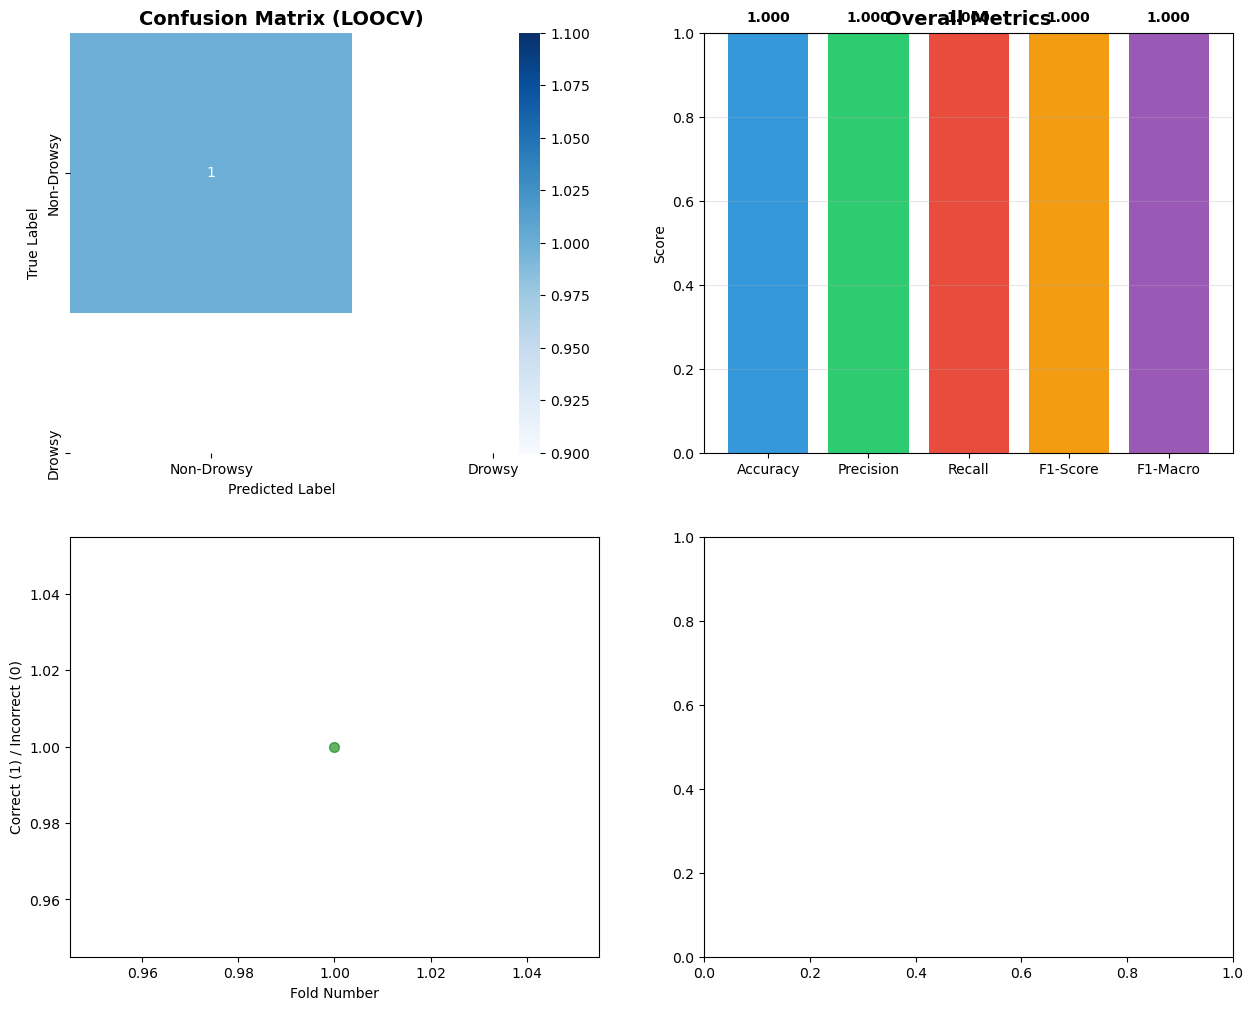

In [100]:
# Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Confusion Matrix
ax = axes[0, 0]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=['Non-Drowsy', 'Drowsy'],
            yticklabels=['Non-Drowsy', 'Drowsy'])
ax.set_title('Confusion Matrix (LOOCV)', fontsize=14, fontweight='bold')
ax.set_ylabel('True Label')
ax.set_xlabel('Predicted Label')

# 2. Metrics Bar Chart
ax = axes[0, 1]
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'F1-Macro']
metrics_values = [accuracy, precision, recall, f1_binary, f1_macro]
bars = ax.bar(metrics_names, metrics_values, color=['#3498db', '#2ecc71', '#e74c3c', '#f39c12', '#9b59b6'])
ax.set_ylim([0, 1])
ax.set_ylabel('Score')
ax.set_title('Overall Metrics', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
for i, (bar, val) in enumerate(zip(bars, metrics_values)):
    ax.text(bar.get_x() + bar.get_width()/2, val + 0.02, f'{val:.3f}', 
            ha='center', va='bottom', fontweight='bold')

# 3. Per-fold correctness
ax = axes[1, 0]
fold_nums = [r['fold'] for r in fold_results]
correctness = [1 if r['correct'] else 0 for r in fold_results]
colors = ['green' if c else 'red' for c in correctness]
ax.scatter(fold_nums, correctness, c=colors, alpha=0.6, s=50)
ax.set_xlabel('Fold Number')
ax.set_ylabel('Correct (1) / Incorrect (0)')
ax.set_title(f'Prediction Correctness per Fold ({correct_folds}/{n_samples} correct)', 
             fontsize=14, fontweight='bold')
ax.set_yticks([0, 1])
ax.set_yticklabels(['Incorrect', 'Correct'])
ax.grid(alpha=0.3)

# 4. Training loss distribution across folds
ax = axes[1, 1]
train_losses = [r['best_train_loss'] for r in fold_results]
ax.hist(train_losses, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
ax.axvline(np.mean(train_losses), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(train_losses):.4f}')
ax.set_xlabel('Best Training Loss')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Best Training Loss Across Folds', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('loocv_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nVisualization saved to 'loocv_results.png'")

In [101]:
# Summary Report
print("\n" + "=" * 80)
print("TRAINING SUMMARY REPORT")
print("=" * 80)

print(f"\nDataset Information:")
print(f"  Total samples: {n_samples}")
print(f"  Non-drowsy samples: {num_non_drowsy}")
print(f"  Drowsy samples: {num_drowsy}")
print(f"  Class balance: {num_non_drowsy/num_drowsy:.2f}:1")

print(f"\nModel Architecture:")
print(f"  Feature Extractor: EfficientNetB0 (frozen)")
print(f"  Temporal Encoder: Bidirectional LSTM (hidden=128)")
print(f"  Classifier: MLP (256→64→1)")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")

print(f"\nTraining Configuration:")
print(f"  Cross-validation: Leave-One-Out (LOOCV)")
print(f"  Total folds: {n_samples}")
print(f"  Epochs per fold: {num_epochs_per_fold}")
print(f"  Batch size: {batch_size}")
print(f"  Learning rate: 5e-4")
print(f"  Optimizer: Adam")
print(f"  Loss: BCEWithLogitsLoss (pos_weight={pos_weight_value:.2f})")

print(f"\nFinal Performance:")
print(f"  Accuracy:      {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"  Precision:     {precision:.4f}")
print(f"  Recall:        {recall:.4f}")
print(f"  F1-Score:      {f1_binary:.4f}")
print(f"  F1-Macro:      {f1_macro:.4f}")

print(f"\nConfusion Matrix:")
print(f"  True Negatives:  {cm[0,0]}")
print(f"  False Positives: {cm[0,1]}")
print(f"  False Negatives: {cm[1,0]}")
print(f"  True Positives:  {cm[1,1]}")

print("\n" + "=" * 80)
print("Analysis Complete!")
print("=" * 80)


TRAINING SUMMARY REPORT

Dataset Information:
  Total samples: 120
  Non-drowsy samples: 60
  Drowsy samples: 60
  Class balance: 1.00:1

Model Architecture:
  Feature Extractor: EfficientNetB0 (frozen)
  Temporal Encoder: Bidirectional LSTM (hidden=128)
  Classifier: MLP (256→64→1)
  Total parameters: 4,747,261
  Trainable parameters: 739,713

Training Configuration:
  Cross-validation: Leave-One-Out (LOOCV)
  Total folds: 120
  Epochs per fold: 30
  Batch size: 8
  Learning rate: 5e-4
  Optimizer: Adam
  Loss: BCEWithLogitsLoss (pos_weight=1.00)

Final Performance:
  Accuracy:      1.0000 (100.00%)
  Precision:     1.0000
  Recall:        1.0000
  F1-Score:      1.0000
  F1-Macro:      1.0000

Confusion Matrix:
  True Negatives:  1


IndexError: index 1 is out of bounds for axis 1 with size 1